In [109]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, sys, itertools


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.operon import get_operon_name_set, get_operon_ID_set
from util.gene import get_gene_bnum
pd.options.display.max_columns = 100

In [110]:
all_muts_df = pd.read_pickle("./data/4_df.pkl")
display(muts_df.shape, muts_df.head())

(2537, 38)

,index,Details,mutation target annotation,Mut ID,Mutation Type,Position,Reference Seq,Sequence Change,ale,exp,flask,isolate,presence,tech_rep,coding,range,gene RegulonDB ID,genetic features,oriC,pseudogene,TFBS,promoter,TSS,RBS,cis-regulatory RNA,attenuator terminator,terminator,genetic,genomic features,taxonomy-id,strain-description,base-media,temperature,carbon-source,nitrogen-source,phosphorous-source,sulfur-source,supplement
0,2,R110G (CGT→GGT),clsA,NaN,SNP,1308318,NaN,G→C,1,42C,124,1,1.0,1,True,"(1308318, 1308318)",{ECK120001556},"[{'name': 'clsA', 'RegulonDB ID': 'ECK12000155...",False,False,{},{},{},{},{},{},{},True,"[{'name': 'clsA', 'RegulonDB ID': 'ECK12000155...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements
1,6,None,rph,NaN,DEL,3815859,NaN,Δ82 bp,1,42C,124,1,1.0,1,True,"(3815859, 3815940)",{ECK120000854},"[{'name': 'rph', 'RegulonDB ID': 'ECK120000854...",False,False,{},{},{},{},{},{ECK125144791},{},True,"[{'name': 'rph-pyrE attenuator terminator', 'R...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements
2,7,A734V (GCG→GTG),rpoC,NaN,SNP,4187550,NaN,C→T,1,42C,124,1,1.0,1,True,"(4187550, 4187550)",{ECK120000886},"[{'name': 'rpoC', 'RegulonDB ID': 'ECK12000088...",False,False,{},{ECK125239996},{},{},{},{},{},True,"[{'name': 'rpoC', 'RegulonDB ID': 'ECK12000088...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements
3,8,D9A (GAT→GCT),hfq,NaN,SNP,4400313,NaN,A→C,1,42C,124,1,1.0,1,True,"(4400313, 4400313)",{ECK120000431},"[{'name': 'hfq', 'RegulonDB ID': 'ECK120000431...",False,False,{},{},{},{},{},{},{},True,"[{'name': 'hfq', 'RegulonDB ID': 'ECK120000431...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements
4,0,coding (380‑400/1149 nt),nagA,NaN,DEL,702352,NaN,Δ21 bp,1,42C,124,1,1.0,1,True,"(702352, 702372)",{ECK120000625},"[{'name': 'nagA', 'RegulonDB ID': 'ECK12000062...",False,False,{},{},{},{},{},{},{},True,"[{'name': 'nagA', 'RegulonDB ID': 'ECK12000062...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements


In [111]:
# removing external ALE experiment since hadn't used an ALE machine and therefore has complicating stationary phase mutations
all_muts_df = all_muts_df[~all_muts_df.exp.str.contains("LTEE")]
len(all_muts_df)

1732

In [112]:
cog_df = pd.read_csv("./data/cogs_ecoli_mg1655.csv", encoding = "ISO-8859-1")
cog_df = cog_df.drop(["GI", "COG ID", "COG name", "COG category"], axis=1).drop_duplicates()
cog_df.head()

,gene,locus,COG category primary,COG class,COG description
0,thrA,b0002,E,METABOLISM,Amino acid transport and metabolism
1,metL,b3940,E,METABOLISM,Amino acid transport and metabolism
4,lysC,b4024,E,METABOLISM,Amino acid transport and metabolism
5,thrB,b0003,E,METABOLISM,Amino acid transport and metabolism
6,thrC,b0004,E,METABOLISM,Amino acid transport and metabolism


In [113]:
TU_objects_df = pd.read_csv("./data/RegulonDB10/tu_objects_tmp.txt",
                            sep="\t",
                            comment='#',
                            header=None,
                            )

TU_objects_df.columns = [
    "TRANSCRIPTION_UNIT_ID",
    "NUMTU",
    "TU_POSLEFT",
    "TU_POSRIGHT",
    "TU_TYPE",
    "TU_OBJECT_CLASS",
    "TU_OBJECT_ID",
    "TU_OBJECT_NAME",
    "TU_OBJECT_POSLEFT",
    "TU_OBJECT_POSRIGHT",
    "TU_OBJECT_STRAND",
    "TU_OBJECT_COLORCLASS",
    "TU_OBJECT_DESCRIPTION",
    "TU_OBJECT_SIGMA",
    "TU_OBJECT_EVIDENCE",
    "TU_OBJECT_RI_TYPE",
    "TU_OBJECT_TYPE",
    "EVIDENCE"]


operon_df = pd.read_csv("./data/RegulonDB10/operon.txt", sep="\t", comment='#', header=None)
operon_df.columns = [
    "OPERON_ID",
    "OPERON_NAME",
    "FIRSTGENEPOSLEFT",
    "LASTGENEPOSRIGHT",
    "REGULATIONPOSLEFT",
    "REGULATIONPOSRIGHT",
    "OPERON_STRAND",
    "OPERON_INTERNAL_COMMENT",
    "KEY_ID_ORG"]
operon_df["range"] = operon_df.apply(lambda row: (row["REGULATIONPOSLEFT"], row["REGULATIONPOSRIGHT"]), axis=1)


TU_df = pd.read_csv("./data/RegulonDB10/transcription_unit.txt", sep="\t", comment='#', header=None)
TU_df.columns = [
    "TRANSCRIPTION_UNIT_ID",
    "PROMOTER_ID",
    "TRANSCRIPTION_UNIT_NAME",
    "OPERON_ID",
    "TRANSCRIPTION_UNIT_NOTE",
    "TU_INTERNAL_COMMENT",
    "KEY_ID_ORG"]

In [114]:
gene_synonym_df = pd.read_csv(
    "./data/RegulonDB10/object_synonym.txt",
    sep="\t",
    comment='#',
    header=None,
    quoting=3
)
gene_synonym_df.columns = ["OBJECT_ID", "OBJECT_SYNONYM_NAME", "OS_INTERNAL_COMMENT", "KEY_ID_ORG"]
gene_synonym_df.head()

,OBJECT_ID,OBJECT_SYNONYM_NAME,OS_INTERNAL_COMMENT,KEY_ID_ORG
0,ECK120000001,EG10001,NaN,ECK12
1,ECK120000001,ECK4045,NaN,ECK12
2,ECK120000001,b4053,NaN,ECK12
3,ECK120000001,alr5,NaN,ECK12
4,ECK120000002,b0764,NaN,ECK12


In [115]:
def _get_COGs(gene_id):
    annots = []
    bnum = get_gene_bnum(gene_id, gene_synonym_df)
    gene_cog_df = cog_df[cog_df["locus"] == bnum]
    if len(gene_cog_df) > 0:
        for COG in gene_cog_df["COG description"]:
            d = {"name": COG}
            annots.append(d)
    return annots


def get_COGs(mut_row):
    annots = []
    for feat_d in mut_row["genomic features"]:
        # !!! This part only handles mutations that land within a genomic feature.
        # Need to also implement logic for handling mutations that land within intergenic regions.
        if feat_d["genetic"]:
            annots += _get_COGs(feat_d["RegulonDB ID"])
            feat_d["COGs"] = annots
        # This will catch whether no features exist in the feat_ID_set
        # or if those features are just integenic regions.
        # Get operon genetic feature link dict through overlapping mutation and operon ranges.
        # All genetic features are annotated within both the "genetic features" and "genetic feature links" column.
        # If no integenic genomic feature is hit by a mutation, use the genetic feature range in an overlap analysis with operons.
        else:
            TU_IDs = set(TU_objects_df[TU_objects_df["TU_OBJECT_ID"]==feat_d["RegulonDB ID"]]["TRANSCRIPTION_UNIT_ID"])
            for TU_ID in TU_IDs:
                subset_TU_genes_df = TU_objects_df[(TU_objects_df["TRANSCRIPTION_UNIT_ID"]==TU_ID) & (TU_objects_df["TU_OBJECT_CLASS"]=='GN')]
                for gene_id in subset_TU_genes_df["TU_OBJECT_ID"].drop_duplicates():
                    if str(gene_id) != 'nan' and gene_id != '':  # RegulonDB can return 'nan' or '' gene names
                        annots += _get_COGs(gene_id)
                        feat_d["COGs"] = annots


_ = all_muts_df.apply(lambda r: get_COGs(r), axis=1)
all_muts_df.head()

,index,Details,mutation target annotation,Mut ID,Mutation Type,Position,Reference Seq,Sequence Change,ale,exp,flask,isolate,presence,tech_rep,coding,range,gene RegulonDB ID,genetic features,oriC,pseudogene,TFBS,promoter,TSS,RBS,cis-regulatory RNA,attenuator terminator,terminator,genetic,genomic features,taxonomy-id,strain-description,base-media,temperature,carbon-source,nitrogen-source,phosphorous-source,sulfur-source,supplement
0,2,R110G (CGT→GGT),clsA,NaN,SNP,1308318,NaN,G→C,1,42C,124,1,1.0,1,True,"(1308318, 1308318)",{ECK120001556},"[{'name': 'clsA', 'RegulonDB ID': 'ECK12000155...",False,False,{},{},{},{},{},{},{},True,"[{'name': 'clsA', 'RegulonDB ID': 'ECK12000155...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements
1,6,None,rph,NaN,DEL,3815859,NaN,Δ82 bp,1,42C,124,1,1.0,1,True,"(3815859, 3815940)",{ECK120000854},"[{'name': 'rph', 'RegulonDB ID': 'ECK120000854...",False,False,{},{},{},{},{},{ECK125144791},{},True,"[{'name': 'rph-pyrE attenuator terminator', 'R...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements
2,7,A734V (GCG→GTG),rpoC,NaN,SNP,4187550,NaN,C→T,1,42C,124,1,1.0,1,True,"(4187550, 4187550)",{ECK120000886},"[{'name': 'rpoC', 'RegulonDB ID': 'ECK12000088...",False,False,{},{ECK125239996},{},{},{},{},{},True,"[{'name': 'rpoC', 'RegulonDB ID': 'ECK12000088...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements
3,8,D9A (GAT→GCT),hfq,NaN,SNP,4400313,NaN,A→C,1,42C,124,1,1.0,1,True,"(4400313, 4400313)",{ECK120000431},"[{'name': 'hfq', 'RegulonDB ID': 'ECK120000431...",False,False,{},{},{},{},{},{},{},True,"[{'name': 'hfq', 'RegulonDB ID': 'ECK120000431...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements
4,0,coding (380‑400/1149 nt),nagA,NaN,DEL,702352,NaN,Δ21 bp,1,42C,124,1,1.0,1,True,"(702352, 702372)",{ECK120000625},"[{'name': 'nagA', 'RegulonDB ID': 'ECK12000062...",False,False,{},{},{},{},{},{},{},True,"[{'name': 'nagA', 'RegulonDB ID': 'ECK12000062...",511145,BOP27,M9,42 celsius,glucose(4),NH4Cl(1),KH2PO4(3),MgSO4(0.24),trace elements


In [116]:
# just to get list of COGs
cog_s = set()
for _, r in all_muts_df.iterrows():
    for f in r["genomic features"]:
        if "COGs" in f.keys():
            for c in f["COGs"]:
                cog_s.add(c["name"])
cog_s

{'Amino acid transport and metabolism',
 'Carbohydrate transport and metabolism',
 'Cell cycle control, cell division, chromosome partitioning',
 'Cell motility',
 'Cell wall/membrane/envelope biogenesis',
 'Coenzyme transport and metabolism',
 'Defense mechanisms',
 'Energy production and conversion',
 'Extracellular structures',
 'Function unknown',
 'General function prediction only',
 'Inorganic ion transport and metabolism',
 'Intracellular trafficking, secretion, and vesicular transport',
 'Lipid transport and metabolism',
 'Mobilome: prophages, transposons',
 'Nucleotide transport and metabolism',
 'Posttranslational modification, protein turnover, chaperones',
 'Replication, recombination and repair',
 'Secondary metabolites biosynthesis, transport and catabolism',
 'Signal transduction mechanisms',
 'Transcription',
 'Translation, ribosomal structure and biogenesis'}

In [117]:
#Those COGs I'm going to consider "regulatory"
regulatory_COG_set = set(['Posttranslational modification, protein turnover, chaperones',
#                           'Signal transduction mechanisms',  # ? Should I be considering these as are "regulatory"
                          'Transcription',
                          'Translation, ribosomal structure and biogenesis'
                         ])

In [118]:
reg_prop_df = pd.DataFrame()
for exp_ale_name_tuple, ale_mut_df in all_muts_df.groupby(["exp", "ale"]):
    if ale_mut_df.ale.iloc[0] != 0:  # Ignoring starting strain mutations
        ale_total_feat_mut_count = 0
        ale_reg_mut_count = 0
        for _, m in ale_mut_df.iterrows():
            for f in m["genomic features"]:
                ale_total_feat_mut_count += 1
                if f["genetic"] == False:
                    ale_reg_mut_count += 1
                else:
                    for c in f['COGs']:
                        if c["name"] in regulatory_COG_set:
                            ale_reg_mut_count += 1
                            break

                
        reg_prop_df = reg_prop_df.append({
            "exp":ale_mut_df.exp.iloc[0],
            "ale":ale_mut_df.ale.iloc[0],
            "regulatory mutation proportion":ale_reg_mut_count/ale_total_feat_mut_count},
            ignore_index=True)
reg_prop_df.head()

,ale,exp,regulatory mutation proportion
0,1.0,42C,0.333333
1,2.0,42C,0.400000
2,3.0,42C,0.363636
3,4.0,42C,0.555556
4,5.0,42C,0.636364


Text(0.5, 0, 'public ALEdb\nexperiments')

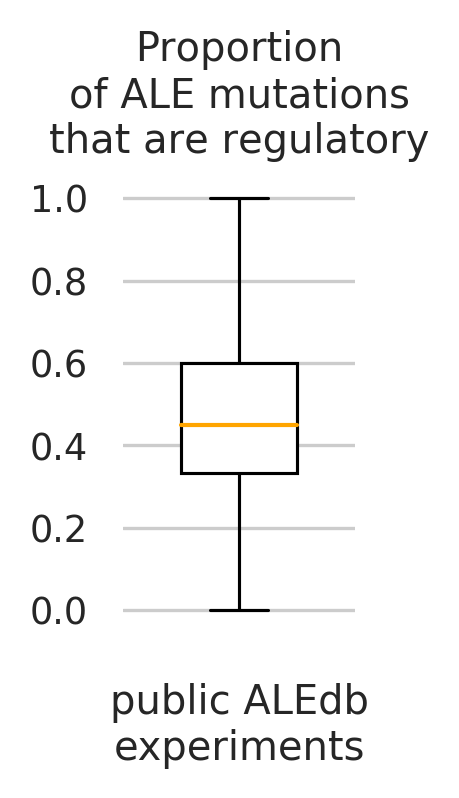

In [139]:
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_context("paper")
sns.set_style("whitegrid")


boxplot_kwargs = {
    'boxprops': {'edgecolor': 'k', 'linewidth': 0.75},
    'whiskerprops': {'color': 'k', 'linewidth': 0.75},
    'medianprops': {'color': 'orange', 'linewidth': 1},
    'capprops': {'color': 'k', 'linewidth': 0.75},
    'flierprops': {'marker': '.', 'markerfacecolor': 'black', 'markeredgecolor': None}
}

# figure size in inches
rcParams['figure.figsize'] = 1, 2


# fig, ax = plt.subplots(figsize=(6, 3))
ax = sns.boxplot(
    y="regulatory mutation proportion",
    data=reg_prop_df,
    width=0.5,
    color="white",
    **boxplot_kwargs
)
# ax.set_title("Proportion of\nregulatory mutations\nin an ALE experiment")
ax.set_title("Proportion\nof ALE mutations\nthat are regulatory")
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
# ax.set_ylabel("proportion of\nregulatory mutations\nfor an ALE experiment")
ax.set_ylabel('')
ax.set_xlabel('public ALEdb\nexperiments')